In [1]:
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [3]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [3]:
bag1 = rosbag.Bag('waypoint/overtakes.bag')
bag1.get_type_and_topic_info()
content1 = []
print(bag1)
# input_steer = []
for topic, msg, _ in bag1.read_messages(topics=['/scan']):
    content1.append(msg)
print(content1[0])

path:        waypoint/overtakes.bag
version:     2.0
duration:    26.4s
start:       Dec 08 2019 20:01:12.09 (1575810072.09)
end:         Dec 08 2019 20:01:38.49 (1575810098.49)
size:        3.8 MB
messages:    17563
compression: none [5/5 chunks]
types:       barc/ECU                  [e60fd3690167c0df782fc50cceb5ce82]
             barc/Encoder              [32ae9320a3544d34b8e4e844525161ab]
             geometry_msgs/PoseStamped [d3812c3cbc69362b77dc0b19b345f8f5]
             sensor_msgs/Imu           [6a62c6daae103f4ff57a132d6f95cec2]
             sensor_msgs/LaserScan     [90c7ef2dc6895d81024acba2ac42f369]
             tf2_msgs/TFMessage        [94810edda583a504dfda3829e70d7eec]
topics:      /ego_pose       3161 msgs @ 120.0 Hz : geometry_msgs/PoseStamped
             /imu/data       2634 msgs @  83.5 Hz : sensor_msgs/Imu          
             /rc_inputs       973 msgs @  37.2 Hz : barc/ECU                 
             /red_pose       3161 msgs @ 120.0 Hz : geometry_msgs/PoseStam

In [5]:
bag2 = rosbag.Bag('waypoint/2021-04-06-11-35-48.bag')
bag2.get_type_and_topic_info()
content2 = []
print(bag2)
# input_steer = []
for topic, msg, _ in bag2.read_messages(topics=['/state_estimator']):
    content2.append(msg)
print(content2[0])

path:        waypoint/2021-04-06-11-35-48.bag
version:     2.0
duration:    48.3s
start:       Jan 01 1970 07:01:29.71 (89.71)
end:         Jan 01 1970 07:02:18.01 (138.01)
size:        121.7 MB
messages:    178070
compression: none [158/158 chunks]
types:       dynamic_reconfigure/Config              [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription   [757ce9d44ba8ddd801bb30bc456f946f]
             gazebo_msgs/LinkStates                  [48c080191eb15c41858319b4d8a609c2]
             gazebo_msgs/ModelStates                 [48c080191eb15c41858319b4d8a609c2]
             geometry_msgs/PoseArray                 [916c28c5764443f268b296bb671b9d97]
             geometry_msgs/PoseWithCovarianceStamped [953b798c0f514ff060a53a3498ce6246]
             nav_msgs/Odometry                       [cd5e73d190d741a2f92e81eda573aca7]
             prius_msgs/Control                      [643e03b408b8368cf4ae109e399336ec]
             rosgraph_msgs/Clock              

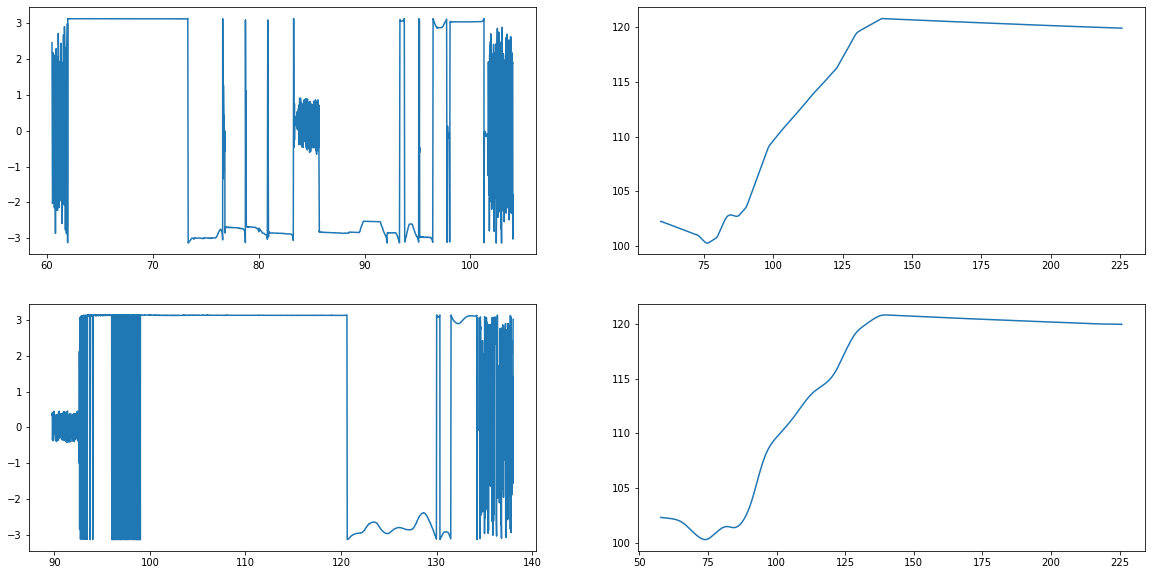

In [13]:
# waypoint (target)
x_target = []
y_target = []
yaw_target = []
waktu_target = []
# actual (simulasi)
x_actual = []
y_actual = []
yaw_actual = []
waktu_actual = []
# data posisi + yaw target
for topic, msg, _ in bag1.read_messages(topics=['/state_estimator']):
    x_target.append(msg.x_est)
    y_target.append(msg.y_est)
    yaw_target.append(msg.yaw_gnss_fr)
    waktu_target.append(msg.header.stamp.to_sec())
yaw_target = wrap_angle(np.array(yaw_target))
# data posisi + yaw actual
for topic, msg, _ in bag2.read_messages(topics=['/state_estimator']):
    x_actual.append(msg.x_est)
    y_actual.append(msg.y_est)
    yaw_actual.append(msg.yaw_gnss_fr)
    waktu_actual.append(msg.header.stamp.to_sec())
yaw_actual = wrap_angle(np.array(yaw_actual))
# # dari state estimator target
# plt.subplot(221)
# plt.plot(waktu_target,yaw_target)
# plt.subplot(222)
# plt.plot(x_target,y_target)
# plt.axis('equal')
# # dari state estimator actual
# plt.subplot(223)
# plt.plot(waktu_actual,yaw_actual)
# plt.subplot(224)
# plt.plot(x_actual,y_actual)
# plt.axis('equal')

f = plt.figure(figsize=(20,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.plot(waktu_target,yaw_target)
ax2.plot(x_target,y_target)
ax3.plot(waktu_actual,yaw_actual)
ax4.plot(x_actual,y_actual)

# plt.legend()
# plt.show()
# print(yaw)

In [47]:
print(len(waktu_amcl),len(x_coor),len(waktu_estimator),len(x_estimator),len(waktu_yaw),len(yaw))

3814 3814 2149 2149 436 436


In [48]:
# Filter the waypoints and remove the outlier !
reverse_index = False
X = np.copy(x_estimator)
Y = np.copy(y_estimator)
# Y = Y + 1
T = np.copy(waktu_estimator)
YAW = np.copy(yaw_estimator)
if reverse_index:

    YAW = YAW + np.pi
    YAW = wrap_angle(YAW)
    X = np.flip(X)
    Y = np.flip(Y)
    T = np.flip(T)
    YAW = np.flip(YAW)

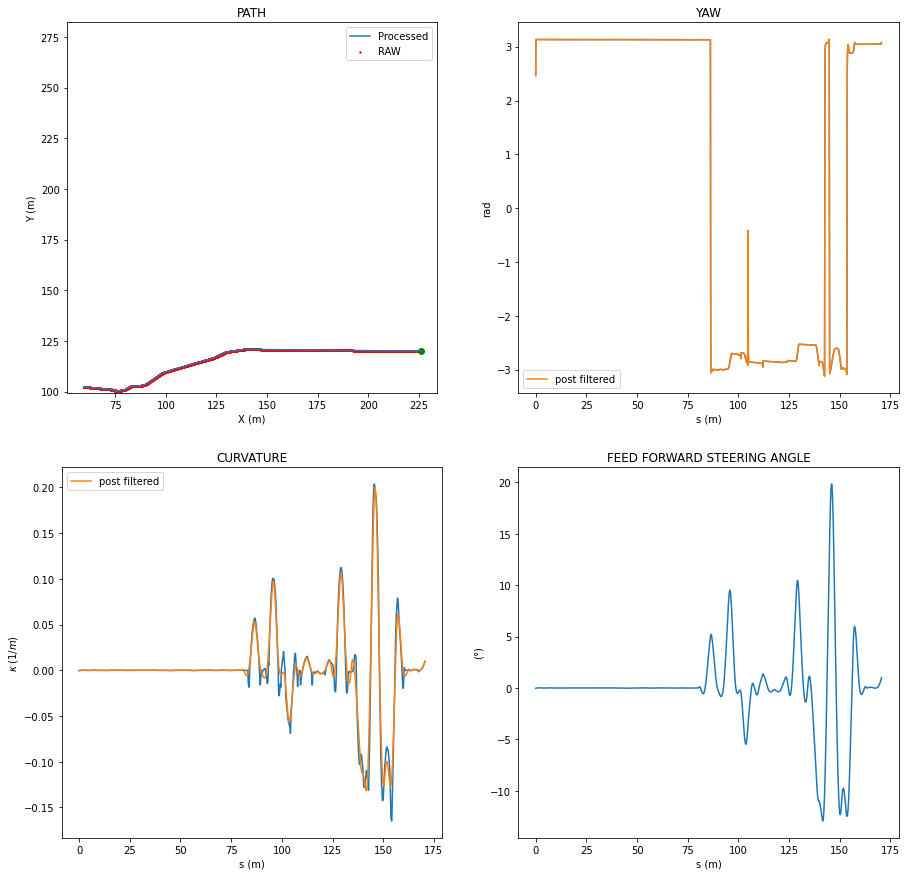

In [49]:
num_f = 61

dst = 0.1

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
# wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))
wp_yaw_f = np.copy(wp_yaw)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x_coor, y_coor, color='red',s=2., label='RAW')
plt.scatter(wp_x[0], wp_y[0], c="g", s=35)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")
plt.axis('square')

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

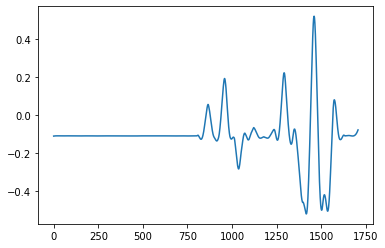

In [50]:
plt.plot(np.interp(steer,[-28,35],[-1,1]))

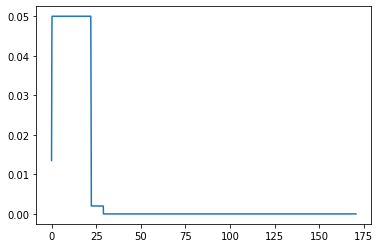

In [51]:
# # THROTTLEEEEE

# # Generate the velocity
v0 = 0.0135 #m/s ~ 1.8 km/jam
vstop = 0.002
vmax = 0.05 # 0.275 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
const = 7.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 29:
        vel[i] = 0.0
    elif s[i] >= 22:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [52]:
waypoints_np = np.empty((wp_x_f.shape[0], 5))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

In [53]:
INTERP_DISTANCE_RES = 0.01 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [54]:
np.save('selasa_6_Apr_2', wp_interp)
wp_interp.shape

(15816, 5)

In [56]:
jreng=np.load('selasa_6_Apr_2.npy')
jreng.shape

(15816, 5)

In [20]:
class Cat:
    def __init__(self, name, age, x_valls, y_valls):
        self.name = name
        self.age = age
        self.x = x_valls
        self.y = y_valls

    def info(self):
        print(f"I am a cat. My name is {self.name}. I am {self.age} years old.")
        zzz = self.x * self.y
        return zzz

    def make_sound(self):
        print("Meow")

In [21]:
asdasd = Cat("robert",2,3,4)

In [22]:
yutt = asdasd.info()
yutt

I am a cat. My name is robert. I am 2 years old.


12

In [15]:
import numpy as np
import numpy.matlib
# asd = np.empty(shape=[1, 0])
# asd
Level_ratio = np.array([[0.2, 0.8]])
Level_ratio = np.array([[0.99, 0.01]])
Level_ratio = np.matlib.repmat(Level_ratio, 4 * (4-1), 1)

In [17]:
Level_ratio_history=np.zeros((1, 30, np.shape(Level_ratio)[0], np.shape(Level_ratio)[1]))

In [34]:
# Level_ratio_history
x = np.empty(shape=[1, 0])
np.append(,[[5]], axis=1)

ValueError: zero-dimensional arrays cannot be concatenated